## **Introduction to ADCNet: Predicting ADC Activity with DeepChem**

Antibody-Drug Conjugates (ADCs) can transform cancer treatment in the era of precision medicine by enabling targeted delivery of potent drugs to cancer cells, minimizing damage to healthy tissues. However, designing effective ADCs remains challenging due to the complex relationship between their molecular structures and therapeutic activities. To address this, we introduce ADCNet [[1]](#1), a unified deep learning framework that facilitates the rational design of ADCs. ADCNet integrates the protein representation learning model ESM-2 for antibody and antigen sequences with the small-molecule representation model FG-BERT for linker and payload SMILES strings, alongside the Drug-Antibody Ratio (DAR) value, to predict ADC activity with high accuracy.

In this tutorial, we will explore how to predict the therapeutic activity of Antibody-Drug Conjugates (ADCs) using ADCNet, a unified deep learning framework implemented in DeepChem. To build a foundational understanding of ADCs, refer to the "Introduction to Antibody-Drug Conjugates" [[2]](#2) notebook available in the DeepChem tutorials before proceeding with this guide.

# **Colab**
This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/ADCNet.ipynb)

## **Background on Drug Discovery and ADCs**

With advancements in molecular biology, target-oriented drug discovery has become the dominant approach, aiming to identify selective and effective clinical candidates. Traditional small molecule inhibitors have shown success but suffer from limitations such as off-target effects, narrow therapeutic windows, and drug resistance. The development of monoclonal antibodies has addressed some of these issues by leveraging specific antigen expression, though their effectiveness against heterogeneous cancer cells remains limited. Antibody-Drug Conjugates (ADCs) emerged as an innovative solution, combining the targeting precision of antibodies with the cytotoxicity of toxins via suitable linkers, enhancing therapeutic efficacy while minimizing harm to healthy cells.

## **Overview of the model architecture**

We have three steps of execution first is processing different types of input data; second, generating embeddings from these inputs using pretrained models; and lastly, concteanting the embeddings and feeding them into a Multilayer Perceptron (MLP) to predict the outcome.

### Inputs

So lets know about the inputs, we have three different forms of inputs. 

(I) Protein Sequences:

- Antibody Heavy Chain: Protein sequence of the antibody's heavy chain.
- Antibody Light Chain: Protein sequence of the antibody's light chain.
- Antigen: Protein sequence of the target antigen.

(II) Small Molecules (SMILES representations):

- Linker: SMILES string representing the chemical structure of the linker.
- Payload: SMILES string representing the chemical structure of the cytotoxic payload.

(III) Numerical Value:

- Drug–Antibody Ratio (DAR): A value indicating the average number of payload molecules attached to each antibody.

Each input is processed separately to extract its unique features.

### Generating Embeddings

ADCNet uses pre-trained language models to transform the inputs into embeddings:

- Protein sequences (antibody heavy chain, antibody light chain, and antigen sequences) are processed using ESM-2 (Evolutionary Scale Modeling) [[3]](#3), a Transformer-based protein language model. ESM-2 converts these sequences into dense embeddings that encode their structural and functional properties.

- SMILES representations of the linker and payload are processed using ChemBERTA. ChemBERTA generates embeddings that capture the chemical properties of these small molecules. <br>

   **Note**: While the original ADCNet paper used FGBERT, ChemBERTA is utilized here due to its availability and effectiveness in the DeepChem framework.

### Prediction

After generating the embeddings,

- The embeddings from the three protein sequences (heavy chain, light chain, and antigen), the two small molecules (linker and payload), and the processed DAR value are concatenated into a single feature vector.
- This combined feature vector is fed into a Multilayer Perceptron (MLP) consisting of two fully connected layers with nonlinear activation functions. The MLP analyzes the concatenated features to predict the ADC's therapeutic activity.

<img src="assets/ADCNet_1.png" alt="image.png" height="300" width="1000"> <br> (A) The mechanism of action of ADCs.

<img src="assets/ADCNet_2.png" alt="image2" height = "900" width="1000"> <br> (B) The network architecture of ADCNet model.
<small>*Diagram illustrating the ADCNet architecture*</small> [[4]](#4)

### Setup

Let's first setup and install necessary libraries.

In [6]:
# install the necessary libraries

!pip install deepchem
!pip install numpy
!pip install torch
!pip install scikit-learn
!pip install transformers
!pip install tqdm

In [7]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from transformers import EsmTokenizer, EsmModel
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

/opt/miniconda3/envs/adcnet/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Collection and Pre-Processing

We will be using ADCdb which is originally used by ADCNet, and accessible at [[5]](#5). It contains data on 6,572 ADCs, including 359 approved by the FDA or in clinical trials, 501 in preclinical testing, 819 with in-vivo testing data, 1,868 with cell line or target testing data, and 3,025 without such testing.

Here we will be using the preprocessed data for convinience found at [[6]](#6). Lets get a look at the dataset, the original dataset is ADCdb ,with data on ADCs, and we include this data from ADCNet, which is preprocessed. This can be found in assets folder or you can find the same in ADCdb github repository.

In [8]:
# load file
file_path = "assets/adcdb.csv"
df = pd.read_csv(file_path)

print(f'We have data of {len(df)} ADCs.')

We have data of 435 ADCs.


In [9]:
df.columns.to_list()

['index',
 'ADC ID',
 'ADC Name',
 'Antibody Name',
 'Antibody Heavy Chain Sequence',
 'Antibody Light Chain Sequence',
 'Antigen Sequence',
 'Payload Isosmiles',
 'Linker Isosmiles',
 'DAR',
 'label（10nm）',
 'label（100nm）',
 'label（1nm）',
 'label（1000nm）',
 'DAR_val']

### Data loading and Overview

We can see the dataset contains columns representing ADC names, antibody sequences, antigen sequences, SMILES strings for linker/payload, and labels at multiple concentrations. Now lets have a preview of the dataset we will be using:

In [10]:
df.head()

,index,ADC ID,ADC Name,Antibody Name,Antibody Heavy Chain Sequence,Antibody Light Chain Sequence,Antigen Sequence,Payload Isosmiles,Linker Isosmiles,DAR,label（10nm）,label（100nm）,label（1nm）,label（1000nm）,DAR_val
0,0,DRG0ABJAM,Trastuzumab-BCN-HydraSpace-Val-Cit-PABC-Gly-Ca...,Trastuzumab,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,CCN(C(=O)CN)C1COC(OC2C(OC3C#C/C=C\C#CC4(O)CC(=...,CC(C)C(NC(=O)OCCN(CCOC(=O)NC(C(=O)NC(CCCNC(N)=...,1.86,0,0,0,0,1.86
1,1,DRG0ZBATX,Anti-KIT NEG087?SSNPP-DM3,Anti-KIT mAb NEG087,EVQLVESGGGLVQPGGSLRLSCAASGFTFSDYYMAWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISSYLNWYQQKPGKAPKL...,MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDL...,C[C@@H]1[C@@H]2C[C@]([C@@H](/C=C/C=C(/CC3=CC(=...,CC(S)CCC(N)=O,3.0-4.0,0,0,0,0,3.50
2,2,DRG0XJKXB,Trastuzumab-C239I-SG3400,Engineered trastuzumab,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQDVNTAVAWYQQKPGKAPKL...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,C=C1CC2C=Nc3cc(OCCCOc4cc5c(cc4OC)C(=O)N4CC(=C)...,C[C@@H](C(=O)NC1=CC=C(C=C1)CO)NC(=O)[C@H](C(C)...,1.71,1,1,1,1,1.71
3,3,DRG0ZOYQV,Datopotamab deruxtecan,Datopotamab,QVQLVQSGAEVKKPGASVKVSCKASGYTFTTAGMQWVRQAPGQGLE...,DIQMTQSPSSLSASVGDRVTITCKASQDVSTAVAWYQQKPGKAPKL...,MARGPGLAPPPLRLPLLLLVLAAVTGHTAAQDNCTCPTNKMTVCSP...,CC[C@@]1(C2=C(COC1=O)C(=O)N3CC4=C5[C@H](CCC6=C...,C1=CC=C(C=C1)C[C@@H](C(=O)NCC(=O)O)NC(=O)CNC(=...,4,1,1,1,1,4.00
4,4,DRG0COMTY,Telisotuzumab vedotin,Telisotuzumab,QVQLVQSGAEVKKPGASVKVSCKASGYIFTAYTMHWVRQAPGQGLE...,DIVMTQSPDSLAVSLGERATINCKSSESVDSYANSFLHWYQQKPGQ...,MKAPAVLAPGILVLLFTLVQRSNGECKEALAKSEMNVNMKYQLPNF...,CC[C@H](C)[C@@H]([C@@H](CC(=O)N1CCC[C@H]1[C@@H...,CC(C)[C@@H](C(=O)N[C@@H](CCCNC(=O)N)C(=O)NC1=C...,3.1,1,1,1,1,3.10


### Preprocessing Numeric Features

We can see we have a important feature DAR (Drugs to Antibody ratio), which is significant in determining the safety of ADCs, as it governs the number of payloads attached to a drug molecule. This is a numerice feature we will be giving as an input to our model, so we will first scale our DAR values, Neural networks converge faster when numeric features share similar distributions. So, we standardize the DAR to zero mean and unit variance.

In [11]:
from sklearn.preprocessing import StandardScaler

# Extract and scale the Drug-Antibody Ratio (DAR)

dar_values = df['DAR_val'].values.reshape(-1, 1)
scaler = StandardScaler()
dar_scaled = scaler.fit_transform(dar_values)

### Generating Embeddings with Pretrained Models

Now, our data is ready and its time to generate embeddings with pre-trained models.

#### Load Pretrained Encoders

Here we will use the smallest version of ESM-2 (esm2_t6_8M_UR50D), trained with 6 layers and 8 Million parameters. Larger ESM-2 models are available in the Transformers library of Hugging Face, see [here](https://huggingface.co/facebook/esm2_t6_8M_UR50D).

In [12]:
from transformers import EsmTokenizer, EsmModel, AutoTokenizer, AutoModel
import torch

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
# Load ESM-2 for protein sequences
esm_model_id = 'facebook/esm2_t6_8M_UR50D'
tokenizer_esm = EsmTokenizer.from_pretrained(esm_model_id)
esm = EsmModel.from_pretrained(esm_model_id).to(device)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


For small molecules we will use ChemBERTA for generating embedddings from SMILES string of payload and linkers.

In [14]:
#  Load the ChemBERTa model and tokenizer

model_chemberta = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer_chemberta = AutoTokenizer.from_pretrained(model_chemberta)
chemberta = AutoModel.from_pretrained(model_chemberta)

Now we have initialized two Transformer-based models: ESM-2 for protein sequences, and ChemBERTa for SMILES. Loading them onto the computation device allows fast embedding extraction.


We will now generate embeddings for the antibody heavy chain, light chain, and antigen protein sequences in our dataset using ESM-2.

In [15]:
# Extract sequences and SMILES from the dataframe

heavy_chains = df['Antibody Heavy Chain Sequence'].astype(str).tolist()
light_chains = df['Antibody Light Chain Sequence'].astype(str).tolist()
antigens = df['Antigen Sequence'].astype(str).tolist()
linkers = df['Linker Isosmiles'].tolist()
payloads = df['Payload Isosmiles'].tolist()

Let's first generate embeddings from protein sequences using ESM-2

In [16]:
MAX_SEQ_LENGTH = 1500

# Function to get embeddings
def get_embeddings(sequences):
    embeddings = []

    for seq in tqdm(sequences, desc="Generating embeddings"):
        inputs = tokenizer_esm(
            seq,
            return_tensors='pt',
            truncation=True,
            padding='max_length',
            max_length=MAX_SEQ_LENGTH,
            is_split_into_words=False
        )

        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = esm(**inputs)
        
        # Extract CLS token
        cls_emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu()
        embeddings.append(cls_emb)

    return embeddings

Now we can use the above function to generate embeddings by passing the sequences as input.

In [17]:
# Generate embeddings from protein sequences
print("Generating embeddings for heavy chains, light chains, and antigens...")

heavy_embeddings = get_embeddings(heavy_chains)
light_embeddings = get_embeddings(light_chains)
antigen_embeddings = get_embeddings(antigens)

Generating embeddings for heavy chains, light chains, and antigens...


Generating embeddings:  25%|██▌       | 109/435 [01:06<03:18,  1.64it/s]


KeyboardInterrupt: 

Now lets move on to genrate embeddings for SMILES of payload and linker.

In [1]:
# Function to get embedding for a single SMILES string
def get_smiles_embedding(smiles: str):
    inputs = tokenizer_chemberta(smiles, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = chemberta(**inputs)
        # Use the CLS token representation (first token)
        embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)
        return embedding.squeeze().cpu().numpy()

In [2]:
# Function to generate embeddings for a list of SMILES
def generate_embeddings(smiles_list):
    embeddings = []
    for smi in tqdm(smiles_list):
        try:
            emb = get_smiles_embedding(smi)
            embeddings.append(emb)
        except Exception as e:
            print(f"Failed for {smi}: {e}")
            embeddings.append(None)
    return embeddings

Embeddings from payload smiles

In [3]:
payload_embeddings = generate_embeddings(payloads) # embeddings from payload smiles

NameError: name 'payloads' is not defined

Embeddings from linker smiles

In [20]:
linker_embeddings = generate_embeddings(linkers) # embeddings from linker smiles

100%|██████████| 435/435 [00:07<00:00, 56.70it/s]


In [21]:
import torch

adc_embeddings = []

num_adcs = len(heavy_embeddings)

for i in range(num_adcs):
    heavy = heavy_embeddings[i]
    light = light_embeddings[i]
    antigen = antigen_embeddings[i]
    payload = payload_embeddings[i]
    linker = linker_embeddings[i]

    # Convert to tensor if not already
    for name, emb in zip(['heavy', 'light', 'antigen'], [heavy, light, antigen]):
        if not isinstance(emb, torch.Tensor):
            locals()[name] = torch.tensor(emb)
    if not isinstance(payload, torch.Tensor):
        payload = torch.tensor(payload)
    if not isinstance(linker, torch.Tensor):
        linker = torch.tensor(linker)

    # Ensure 1D shape
    if payload.dim() == 0:
        payload = payload.unsqueeze(0)
    if linker.dim() == 0:
        linker = linker.unsqueeze(0)

    # Concatenate embeddings
    full_emb = torch.cat([
        heavy,
        light,
        antigen,
        payload,
        linker
    ])  # shape: [combined_dim]

    adc_embeddings.append(full_emb)


In [22]:
print("Payload shape:", payload_embeddings[0].shape)
print("Linker shape:", linker_embeddings[0].shape)
print("Heavy shape:", heavy_embeddings[0].shape)

Payload shape: (768,)
Linker shape: (768,)
Heavy shape: torch.Size([320])


In [23]:
full_emb.shape

torch.Size([2496])

### MODEL- MLP

In [24]:
adc_batch_tensor = torch.stack(adc_embeddings)

In [25]:
adc_batch_tensor.shape

torch.Size([435, 2496])

#### MLP defined

In [26]:
import torch
import torch.nn as nn
from deepchem.models.torch_models.layers import MultilayerPerceptron

# Define the model
model_mlp = MultilayerPerceptron(
    d_input= 2496,
    d_output=1,
    d_hidden=(1024, 256),
    dropout=0.0,
    activation_fn='relu'
)

# Forward pass
op = model_mlp(adc_batch_tensor)
print(op.shape)  # [435, 1]

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/opt/miniconda3/envs/adcnet/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


torch.Size([435, 1])


### Model training from here

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd

In [28]:
# Extract the label
label_col = "label（100nm）"
labels = df[label_col].values  # 0 or 1

# Convert to PyTorch tensor
y = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)  # shape: [10, 1] assuming 10 samples

In [29]:
X_train, X_val, y_train, y_val = train_test_split(adc_batch_tensor, y, test_size=0.2, random_state=42)

In [30]:
# Model, Loss, Optimizer
mode = model_mlp  # using the MLP defined
criterion = nn.MSELoss()
optimizer = optim.Adam(mode.parameters(), lr=1e-4)

In [31]:
# For plotting
train_losses = []
val_losses = []

In [32]:
# Training Loop
epochs = 100
for epoch in range(epochs):
    model_mlp.train()
    optimizer.zero_grad()

    outputs = mode(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    model_mlp.eval()
    with torch.no_grad():
        val_outputs = model_mlp(X_val)
        val_loss = criterion(val_outputs, y_val)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 0 | Train Loss: 0.5761 | Val Loss: 0.2378
Epoch 10 | Train Loss: 0.1983 | Val Loss: 0.1788
Epoch 20 | Train Loss: 0.1782 | Val Loss: 0.1629
Epoch 30 | Train Loss: 0.1612 | Val Loss: 0.1570
Epoch 40 | Train Loss: 0.1476 | Val Loss: 0.1533
Epoch 50 | Train Loss: 0.1349 | Val Loss: 0.1519
Epoch 60 | Train Loss: 0.1225 | Val Loss: 0.1493
Epoch 70 | Train Loss: 0.1101 | Val Loss: 0.1464
Epoch 80 | Train Loss: 0.0982 | Val Loss: 0.1423
Epoch 90 | Train Loss: 0.0877 | Val Loss: 0.1395


In [33]:
model_mlp.eval()
with torch.no_grad():
    preds = model_mlp(X_val)  # shape: [val_size, 1]
    print(preds[:5])

tensor([[0.8468],
        [0.8932],
        [0.1066],
        [0.9155],
        [0.8641]])


In [34]:
print("Predictions:", val_outputs.squeeze().tolist())
print("Ground Truth:", y_val.squeeze().tolist())

Predictions: [0.8467609286308289, 0.8931605219841003, 0.10663480311632156, 0.9154501557350159, 0.8640836477279663, 0.6371089220046997, 1.0207592248916626, 1.0185949802398682, 0.10207720100879669, 1.14719820022583, 1.1092849969863892, 0.6371089220046997, 0.7100212574005127, 0.605150580406189, 1.0342309474945068, 0.5586763620376587, 1.0057750940322876, 0.45945608615875244, 0.7867482900619507, 1.0152472257614136, 0.8240559697151184, 0.24429838359355927, 0.30539101362228394, 0.9516069293022156, 0.8414539098739624, 0.6006705164909363, 0.7297489047050476, 0.09881465137004852, 0.9107796549797058, 0.08529087901115417, 0.26947134733200073, 0.21824994683265686, 0.367184579372406, 0.9084498882293701, 0.695220947265625, 0.21653422713279724, 0.16777007281780243, 0.6371089220046997, 1.072149634361267, 0.5291594862937927, 0.9787214994430542, 0.6696099042892456, 0.6126108169555664, 0.40803009271621704, 0.3624400496482849, 0.9774854183197021, 0.8098796606063843, 0.8972185254096985, 1.028037428855896, 0

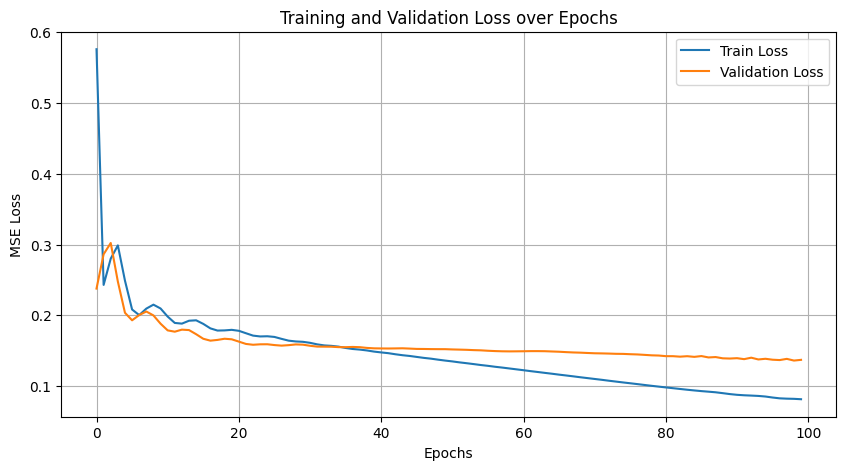

In [35]:
# Plotting loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## References <a name="references"></a>

<a name="1"></a> [1] Chen, L., Li, B., Chen, Y., Lin, M., Zhang, S., Li, C., Pang, Y., & Wang, L. (2024). ADCNet: A unified framework for predicting the activity of antibody‑drug conjugates. https://arxiv.org/pdf/2401.09176

<a name="2"></a> [2] DeepChem Team. (n.d.). Introduction to Antibody-Drug Conjugates. https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_ADCNet.ipynb

<a name="3"></a> [3] Facebook AI Research. (2020). ESM: Evolutionary Scale Modeling [GitHub repository]. https://github.com/facebookresearch/esm

<a name="4"></a> [4] ADCNet githubidrugLab.(2024). ADCNet: a unified framework for predicting the activity of antibody‑drug conjugates. GitHub repository: https://github.com/idrugLab/ADCNet

<a name="5"></a> [5] Shen, L. T., Sun, X. N., Chen, Z., Guo, Y., Shen, Z. Y., Song, Y., Xin, W. X., Ding, H. Y., Ma, X. Y., Xu, W. B., Zhou, W. Y., Che, J. X., Tan, L. L., Chen, L. S., Chen, S. Q., Dong, X. W., Fang, L., & Zhu, F. (2024).
ADCdb: the database of antibody‑drug conjugates. Nucleic Acids Research, 52(D1), D1097–D1109. PMID 37831118.
Website: https://adcdb.idrblab.net/

<a name="6"></a> [6] ADCNet githubidrugLab.(2024). ADCNet: a unified framework for predicting the activity of antibody‑drug conjugates. GitHub repository: https://github.com/idrugLab/ADCNet

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

# Citing this tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.

```
@manual{Molecular Machine Learning,
 title={Introduction to ADCNet: Predicting ADC Activity with DeepChem},
 organization={DeepChem},
 author={Patra, Sonali Lipsa and Bisoi, Ankita and Singh, Rakshit Kr. and Ramsundar, Bharath}
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/ADCNet.ipynb}},
 year={2025},
}
```